## FKA122: H2a | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [156]:

# Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 2000

# Functions
def read_data(task, T, its_eq=0, its=0):
    '''
    Read data from csv files.

    Args:
        task (int): task number.
        T (int): temperature.
        its_eq (int): number of equilibrium iterations.
        its (int): number of MC iterations.
    
    Returns:
        if task == 2:
            eq_data (np.array): equilibrium data.
            eq_facts (np.array): equilibrium facts, i.e. acceptance ratio, its, etc.
            atoms_data (np.array): atoms data, showing which atom is at what position.
            energy_data (np.array): energy data.
            energy_facts (np.array): energy facts, i.e. acceptance ratio, its, etc.
        if task == 3 & T:
            N (int): number of samples.
            auto_corr_data (np.array): autocorrelation data.
            block_data (np.array): block averaging data.
            error_dict_corr (dict): errors from autocorrelation.
            error_dict_block (dict): errors from block averaging.
            var_dict (dict): variance of U, C_V, P, r.
        if task == 3 & not T:
            data (np.array): data from task 3.

    '''
    if task == 2:
        if its_eq:
            eq_facts = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', max_rows=1, delimiter=',', dtype=np.float64)
            eq_data = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', delimiter=',', dtype=np.float64)[1:, :]
        else:
            eq_facts = None
            eq_data = None
        if its:
            atoms_data = np.genfromtxt(f'data/task_2/lattice/atoms_{its_eq}_{its}_{T}.csv')
            energy_facts = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', max_rows=2, delimiter=',', dtype=np.float64)[1]
            energy_data = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', delimiter=',', dtype=np.float64, skip_header=3)
        else:
            atoms_data = None
            energy_facts = None
            energy_data = None
        return eq_data, eq_facts, atoms_data, energy_data, energy_facts
    
    if task == 3:
        if T:
            filename_corr = f'data/task_{task}/auto_corr_{T}.csv'
            filename_block = f'data/task_{task}/blocking_{T}.csv'

            N, var_U, var_CV, var_P, var_r = np.genfromtxt(filename_corr, delimiter=',', dtype=np.float64)[1, :]
            auto_corr_data = np.genfromtxt(filename_corr, delimiter=',', dtype=np.float64)[3:, :]
            block_data = np.genfromtxt(filename_block, delimiter=',', dtype=np.float64)[1:, :]

            # Find the first index where the autocorrelation is less than exp(-2)
            s_corr_U = auto_corr_data[:, 0][np.where(auto_corr_data[:, 1] < np.exp(-2))[0][0]]
            s_corr_CV = auto_corr_data[:, 0][np.where(auto_corr_data[:, 2] < np.exp(-2))[0][0]]
            s_corr_P = auto_corr_data[:, 0][np.where(auto_corr_data[:, 3] < np.exp(-2))[0][0]]
            s_corr_r = auto_corr_data[:, 0][np.where(auto_corr_data[:, 4] < np.exp(-2))[0][0]]

            # Calculate the statistical inefficiency from the blocking data
            s_block_U = np.mean(block_data[:, 1])
            s_block_CV = np.mean(block_data[:, 2])
            s_block_P = np.mean(block_data[:, 3])
            s_block_r = np.mean(block_data[:, 4])

            var_dict = {'U': var_U, 'C_V': var_CV, 'P': var_P, 'r': var_r}
            error_dict_corr = {'U': s_corr_U, 'C_V': s_corr_CV, 'P': s_corr_P, 'r': s_corr_r}
            error_dict_block = {'U': s_block_U, 'C_V': s_block_CV, 'P': s_block_P, 'r': s_block_r}

            return N, auto_corr_data, block_data, error_dict_corr, error_dict_block, var_dict
        else:
            data = np.genfromtxt('data/task_3/data.csv', delimiter=',', dtype=np.float64, skip_header=1)

            return data
    
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    '''
    Code for applying a filter to the sampled data.
    Found here: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay.
    '''
    from math import factorial 
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.asmatrix([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def plot_task_1(quantity, T_c, save=False):
    '''
    Plot data for task 1.

    Args:
        quantity (str): 'UC' or 'P'.
        T_c (float): critical temperature.
        save (bool): whether to save the plot or not.
    '''
    # Read data and define the temperature
    data = np.loadtxt('data/task_1/data.csv', delimiter=',')
    T = data[:, 1]
    if quantity == 'UC':
        data_U = data[:, 2] # Potential energy
        data_C = data[:, 3] # Heat capacity
        fact_U = 0.008 # Factor to increase the y-axis
        fact_C = 0.2 # Factor to increase the y-axis
        
        # Plot the data
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        axs[0].plot(T, data_U, 'k', lw=2.5, label='$U(T)$')
        axs[0].axvline(x=T_c, color='tab:orange', linestyle='--', label='$T_c$')
        axs[0].set_xlabel('$T$ [K]')
        axs[0].set_ylabel('$U(T)$ [eV]')
        axs[0].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[0].legend(loc='upper left', ncol=2)
        axs[0].set_ylim(axs[0].get_ylim()[0], axs[0].get_ylim()[1] + abs(axs[0].get_ylim()[1] * fact_U))

        axs[1].plot(T, data_C, 'k', lw=2.5, label='$C_V(T)$')
        axs[1].axvline(x=T_c, color='tab:orange', linestyle='--', label='$T_c$')
        axs[1].set_xlabel('$T$ [K]')
        axs[1].set_ylabel('$C_V(T)$ [eV/K]')
        axs[1].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[1].legend(loc='upper left', ncol=2)
        axs[1].set_ylim(axs[1].get_ylim()[0], axs[1].get_ylim()[1] + abs(axs[1].get_ylim()[1] * fact_C))

        plt.tight_layout()
    elif quantity == 'P':
        data = abs(data[:, 0]) # Long-range order parameter
        y_label = '$\\vert P\\vert$'
        fact = 0.25 # Factor to increase the y-axis

        # Plot the data
        fig = plt.figure(figsize=(7, 6))
        plt.plot(T, data, 'k', lw=2.5, label='$P(T)$')
        plt.axvline(x=T_c, color='tab:orange', linestyle='--', label='$T_c$')
        plt.xlabel('$T$ [K]')
        plt.ylabel(y_label)
        plt.ylim(plt.ylim()[0], plt.ylim()[1] + abs(plt.ylim()[1] * fact))
        plt.grid(linestyle=':', linewidth=1, alpha=0.6)
        plt.legend(loc='upper left', ncol=2)
        plt.tight_layout()

    if save:
        save_fig(fig, f'{quantity}_T', 1)
    plt.show()

def analyzer_task_2(T, its_eq, its, changed=True, plot=False, save=False):
    '''
    Analyze and plot task 2 data.

    Args:
        T (list): temperatures to plot.
        its_eq (list): equilibrium iterations.
        its (list): MC iterations.
        changed (bool): whether to keep only accepted steps or not.
        plot (bool): whether to plot or not (if its).
        save (bool): whether to save the plot or not.
    
    Returns:
        if its is None:
            None.
        if its is not None and changed:
            U_changed (np.array): only the accepted steps of the potential energy.
            acceptance equilibration: acceptance ratio during equilibration.
            acceptance (float): acceptance ratio.
    '''
    # Plot equilibrium data
    if its_eq and its is None:
        fig, axs = plt.subplots(1, len(T), figsize=(20, 10))
        colors = ['tab:blue', 'tab:orange', 'tab:green']
        labels = ['\\textbf{{a)}}', '\\textbf{{b)}}', '\\textbf{{c)}}', '\\textbf{{d)}}', '\\textbf{{e)}}', '\\textbf{{f)}}']
        if len(T) == 3:
            axs = np.array([[axs[0], axs[1], axs[2]]])
        for i, t in enumerate(T):
            data, eq_facts, _, _, _ = read_data(2, t, its_eq=its_eq[i])
            axs[0, i].plot(data[:, 1], lw=2, color=colors[i])
            # axs[1, i].plot(data[:, 1], lw=2, color=colors[i])
            # axs[0, 0].set_ylabel('Accepted steps')
            axs[0, 0].set_ylabel('Potential energy [eV]')
            axs[-1, i].set_xlabel('MC steps')
            axs[0, i].set_title(f'$T = {t}$ K', fontsize=40)
            axs[0, i].set_xticks(np.linspace(0, len(data[:, 0]), 3))
            axs[0, i].text(0.65, 0.2, labels[i], transform=axs[0, i].transAxes, fontsize=50)
            # axs[1, i].text(0.65, 0.2, labels[2*i + 1], transform=axs[1, i].transAxes, fontsize=50)
            # axs[0, i].set_xticks([])
        if save:
            plt.tight_layout()
            save_fig(fig, 'burnin', 2)
    # Plot MC data
    elif its and its_eq:
        _, _, atoms_data, energy_data, energy_facts = read_data(2, T, its_eq=its_eq, its=its)
        accept_diff = np.diff(energy_data[:, 0]) # Difference in accepted steps
        accept_diff = np.insert(accept_diff, 0, True) # Insert True at the beginning
        U_changed = energy_data[:, 1][accept_diff > 0] # Only the accepted steps of the potential energy

        # Plot only the accepted steps
        if plot and changed:
            fig, axs = plt.subplots(1, 2, figsize=(9, 6))
            axs[0].plot(energy_data[:, 0])
            axs[1].plot(U_changed)
            axs[0].set_ylabel('Accepted steps')
            axs[1].set_ylabel('Potential energy [eV]')
            axs[0].set_xlabel('MC steps')
            axs[1].set_xlabel('MC steps')
            plt.tight_layout()
        # Plot all steps
        elif plot and not changed:
            fig, axs = plt.subplots(1, 2, figsize=(9, 6))
            axs[0].plot(energy_data[:, 0])
            axs[1].plot(energy_data[:, 1])
            axs[0].set_ylabel('Accepted steps')
            axs[1].set_ylabel('Potential energy [eV]')
            axs[0].set_xlabel('MC steps')
            axs[1].set_xlabel('MC steps')
            plt.tight_layout()

        if save:
            save_fig(fig, 'MC_steps', 2)
        
        return U_changed, energy_facts[1], energy_data[-1, 0] / len(energy_data[:, 0])
    
    plt.show()
    
def plot_task_3(quantity, n_atoms=2000, save=False, error_plot=False, 
                save_error_plot=False):
    '''
    Plot quantity data for task 3.
    
    Args:
        quantity (str): 'UC' or 'Pr'.
        n_atoms (int): number of atoms.
        save (bool): whether to save the plot or not.
        error_plot (bool): whether to plot the errors or not.
        save_error_plot (bool): whether to save the error plot.
    '''
    # Read data, define the temperature and retrieve the errors
    data = read_data(3, None)
    T = data[1:, 0]
    errors_corr, errors_block, facts = get_errors(list(T))
    # Initialize plot variables
    if quantity == 'UC':
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))
        Y_1 = data[1:, 1]
        Y_2 = data[1:, 2]
        y_label_1 = '$U(T)$ [eV]'
        y_label_2 = '$C_V(T)$ [eV/K]'
        legend_loc = 'upper left'
        ylim_1 = [-2360, -2260]
        ylim_2 = [-0.01, 0.45]
        colors = ['tab:blue', 'tab:orange']
        # Calculate the errors as the average of the errors from autocorrelation and block averaging
        error_1 = (np.array(errors_corr['U'], dtype=np.float64) + np.array(errors_block['U'], dtype=np.float64)) / 2
        error_2 = (np.array(errors_corr['C_V'], dtype=np.float64) + np.array(errors_block['C_V'], dtype=np.float64)) / 2
    elif quantity == 'Pr':
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
        Y_1 = np.abs(data[1:, 3])
        Y_2 = data[1:, 4]
        y_label_1 = '$P(T)$'
        y_label_2 = '$r(T)$'
        legend_loc = 'upper left'
        ylim_1 = [-0.05, 1.3]
        ylim_2 = [-0.05, 1.3]
        colors = ['tab:green', 'tab:red']
        # Calculate the errors as the average of the errors from autocorrelation and block averaging
        error_1 = (np.array(errors_corr['P'], dtype=np.float64) + np.array(errors_block['P'], dtype=np.float64)) / 2
        error_2 = (np.array(errors_corr['r'], dtype=np.float64) + np.array(errors_block['r'], dtype=np.float64)) / 2

    # Plot the data with the errors
    axs[0].errorbar(T, Y_1, yerr=error_1, fmt='-o', ecolor='k', capsize=6, capthick=2.7, linewidth=2.7, label=f'Data Points, {y_label_1.replace(' [eV]', '')}', markersize=7.5, color=colors[0])
    axs[1].errorbar(T, Y_2, yerr=error_2, fmt='-o', ecolor='k', capsize=6, capthick=2.7, linewidth=2.7, label=f'Data Points, {y_label_2.replace(' [eV/K]', '')}', markersize=7.5, color=colors[1])
    # Plot the filtered data
    if quantity == 'UC':
        axs[0].plot(T, savitzky_golay(Y_1, 5, 3), color='k', linewidth = 2.7, label='Filtered', alpha=0.5, linestyle='--')
        axs[1].plot(T, savitzky_golay(Y_2, 5, 3), color='k', linewidth = 2.7, label='Filtered', alpha=0.5, linestyle='--')
    else:
        axs[0].plot(T, savitzky_golay(Y_1, 25, 9), color = 'k',linewidth = 2.7, label='Filtered', alpha=0.5, linestyle='--')
        axs[1].plot(T, savitzky_golay(Y_2, 25, 9), color = 'k',linewidth = 2.7, label='Filtered', alpha=0.5, linestyle='--')
    # Grid, labels and legends
    for ax in axs:
        ax.grid(linestyle=':', linewidth=1, alpha=0.6)
        ax.set_xlabel('$T$ [K]')
        ax.legend(fontsize = 26, loc=legend_loc, ncol=1)
        if ax == axs[0]:
            ax.set_ylabel(y_label_1)
            ax.set_ylim(ylim_1)
        else:
            ax.set_ylabel(y_label_2)
            ax.set_ylim(ylim_2)
    if save:
        plt.tight_layout()
        plt.savefig(f'figs/task_3/{quantity}_T_metro.pdf', bbox_inches='tight')

    # Plot the errors
    if error_plot:
        # Calculate the errors as the average of the errors from autocorrelation and block averaging
        e_U = (np.array(errors_corr['U'], dtype=np.float64) + np.array(errors_block['U'], dtype=np.float64)) / 2
        e_CV = (np.array(errors_corr['C_V'], dtype=np.float64) + np.array(errors_block['C_V'], dtype=np.float64)) / 2
        e_P = (np.array(errors_corr['P'], dtype=np.float64) + np.array(errors_block['P'], dtype=np.float64)) / 2
        e_r = (np.array(errors_corr['r'], dtype=np.float64) + np.array(errors_block['r'], dtype=np.float64)) / 2

        fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharex=True)
        axs[0, 0].bar(T, e_U, color='tab:blue', label='$\\epsilon_{U}$', width=20, edgecolor='k')
        axs[0, 1].bar(T, e_CV, color='tab:orange', label='$\\epsilon_{C_V}$', width=20, edgecolor='k')
        axs[1, 0].bar(T, e_P, color='tab:green', label='$\\epsilon_{P}$', width=20, edgecolor='k')
        axs[1, 1].bar(T, e_r, color='tab:red', label='$\\epsilon_{r}$', width=20, edgecolor='k')
        labels = ['$\\epsilon_{U}$', '$\\epsilon_{C_V}$', '$\\epsilon_{P}$', '$\\epsilon_{r}$']
        for i, ax in enumerate(axs.flatten()):
            ax.grid(linestyle=':', linewidth=1, alpha=0.6)
            ax.legend(loc='upper left', fontsize=32)
            ax.set_ylabel(labels[i])
            ax.set_xticks([400, 600, 800, 1000])
        axs[1, 0].set_xlabel('$T$ [K]')
        axs[1, 1].set_xlabel('$T$ [K]')
        plt.tight_layout()

        if save_error_plot:
            plt.savefig(f'figs/task_3/errors.pdf', bbox_inches='tight')

    plt.show()

def plot_task_3_error(T, autocorr, block, s_corr_U, s_corr_P, s_corr_CV, save=False, 
                      xlim_factor=1., xlim_factor_CVP=1., P_sep=False):
    '''
    Plot the autocorrelation and block averaging data for task 3.

    Args:
        T (int): temperature for which to plot the data.
        autocorr (np.array): autocorrelation data.
        block (np.array): block averaging data.
        s_corr_U (float): statistical inefficiency for the potential energy.
        s_corr_P (float): statistical inefficiency for the long-range order parameter.
        s_corr_CV (float): statistical inefficiency for the heat capacity.
        save (bool): whether to save the plot or not.
        xlim_factor (float): factor to increase the x-axis limit for the potential 
                             energy/long/short-range order parameter.
        xlim_factor_CVP (float): factor to increase the x-axis limit for the 
                                 heat capacity/long-range order parameter.
        P_sep (bool): whether to plot the long-range order parameter separately or not.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    # Plot U, P and r data in one plot and C_V data in the other
    if not P_sep:
        # Autocorrelation data for U, P and r
        axs[0].plot(autocorr[:, 0], autocorr[:, 1], 'tab:blue', lw=5)
        axs[0].plot(autocorr[:, 0], autocorr[:, 3], 'tab:orange', lw=3)
        axs[0].plot(autocorr[:, 0], autocorr[:, 4], 'tab:green', lw=2)
        axs[0].plot([], [], 'tab:blue', label='$U$')
        axs[0].plot([], [], 'tab:orange', label='$P$')
        axs[0].plot([], [], 'tab:green', label='$r$')
        axs[0].axhline(np.exp(-2), color='k', linestyle='-', label='$e^{-2}$')
        axs[0].axvline(s_corr_U, ymin=0.025, ymax=0.365, color='k', linestyle='--')
        axs[0].set_ylim(-0.5, 1.2)
        axs[0].set_xlim(0, s_corr_P * 1.2)
        axs[0].set_ylabel('Autocorrelation $\\Phi_k$')
        axs[0].set_xlabel('MC step $k$')
        axs[0].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[0].legend()
        plt.tight_layout()

        # Block averaging data for U, P and r
        axs[1].plot(block[:, 0], block[:, 1], 'tab:blue', lw=6)
        axs[1].plot(block[:, 0], block[:, 3], 'tab:orange', lw=3)
        axs[1].plot(block[:, 0], block[:, 4], 'tab:green', lw=2)
        axs[1].plot([], [], 'tab:blue', label='$U$')
        axs[1].plot([], [], 'tab:orange', label='$P$')
        axs[1].plot([], [], 'tab:green', label='$r$')
        axs[1].set_ylabel('Statistical Inefficiency $s$')
        axs[1].set_xlabel('Block size')
        axs[1].set_xlim(0, np.max(block[:, 0]) * xlim_factor)
        axs[1].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[1].legend()
        plt.tight_layout()

        if save:
            save_fig(fig, 'auto_corr_block_UPr'+str(T), 3)

        fig, axs = plt.subplots(1, 2, figsize=(10, 6))
        # Autocorrelation data for C_V
        axs[0].plot(autocorr[:, 0], autocorr[:, 2], 'tab:red')
        axs[0].plot([], [], 'tab:red', label='$C_V$')
        axs[0].axhline(np.exp(-2), color='k', linestyle='-', label='$e^{-2}$')
        axs[0].axvline(s_corr_CV, ymin=0.025, ymax=0.365, color='k', linestyle='--')
        axs[0].set_ylim(-0.5, 1.2)
        axs[0].set_xlim(0, s_corr_CV * 1.1)
        axs[0].set_ylabel('Autocorrelation $\\Phi_k$')
        axs[0].set_xlabel('MC step $k$')
        axs[0].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[0].legend()
        plt.tight_layout()

        # Block averaging data for C_V
        axs[1].plot(block[:, 0], block[:, 2], 'tab:red')
        axs[1].plot([], [], 'tab:red', label='$C_V$')
        axs[1].set_ylabel('Statistical Inefficiency $s$')
        axs[1].set_xlabel('Block size')
        axs[1].set_xlim(0, np.max(block[:, 0]) * xlim_factor_CVP)
        axs[1].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[1].legend()
        plt.tight_layout()

        if save:
            save_fig(fig, 'auto_corr_block_CV'+str(T), 3)
    else:
        # Autocorrelation data for U and r
        axs[0].plot(autocorr[:, 0], autocorr[:, 1], 'tab:blue', lw=5)
        axs[0].plot(autocorr[:, 0], autocorr[:, 4], 'tab:green', lw=2)
        axs[0].plot([], [], 'tab:blue', label='$U$')
        axs[0].plot([], [], 'tab:green', label='$r$')
        axs[0].axhline(np.exp(-2), color='k', linestyle='-', label='$e^{-2}$')
        axs[0].axvline(s_corr_U, ymin=0.025, ymax=0.365, color='k', linestyle='--')
        axs[0].set_ylim(-0.5, 1.2)
        axs[0].set_xlim(0, s_corr_U * 1.2)
        axs[0].set_ylabel('Autocorrelation $\\Phi_k$')
        axs[0].set_xlabel('MC step $k$')
        axs[0].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[0].legend()
        plt.tight_layout()

        # Block averaging data for U and r
        axs[1].plot(block[:, 0], block[:, 1], 'tab:blue', lw=6)
        axs[1].plot(block[:, 0], block[:, 4], 'tab:green', lw=2)
        axs[1].plot([], [], 'tab:blue', label='$U$')
        axs[1].plot([], [], 'tab:green', label='$r$')
        axs[1].set_ylabel('Statistical Inefficiency $s$')
        axs[1].set_xlabel('Block size')
        axs[1].set_xlim(0, np.max(block[:, 0]) * xlim_factor)
        axs[1].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[1].legend()
        plt.tight_layout()

        if save:
            save_fig(fig, 'auto_corr_block_Ur'+str(T), 3)

        # Autocorrelation data for P
        fig, axs = plt.subplots(1, 2, figsize=(10, 6))
        axs[0].plot(autocorr[:, 0], autocorr[:, 3], 'tab:orange', lw=3)
        axs[0].plot([], [], 'tab:orange', label='$P$')
        axs[0].axhline(np.exp(-2), color='k', linestyle='-', label='$e^{-2}$')
        axs[0].axvline(s_corr_P, ymin=0.025, ymax=0.365, color='k', linestyle='--')
        axs[0].set_ylim(-0.5, 1.2)
        axs[0].set_xlim(0, s_corr_P * 1.2)
        axs[0].set_ylabel('Autocorrelation $\\Phi_k$')
        axs[0].set_xlabel('MC step $k$')
        axs[0].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[0].legend()
        plt.tight_layout()
        
        # Block averaging data for P
        axs[1].plot(block[:, 0], block[:, 3], 'tab:orange', lw=3)
        axs[1].plot([], [], 'tab:orange', label='$P$')
        axs[1].set_ylabel('Statistical Inefficiency $s$')
        axs[1].set_xlabel('Block size')
        axs[1].set_xlim(0, np.max(block[:, 0]) * xlim_factor_CVP)
        axs[1].grid(linestyle=':', linewidth=1, alpha=0.6)
        axs[1].legend()
        plt.tight_layout()

        if save:
            save_fig(fig, 'auto_corr_block_P'+str(T), 3)        

    plt.show()

def get_errors(Ts):
    '''
    Calculate the errors for task 3.

    Args:
        Ts (list): temperatures for which to calculate the errors.

    Returns:
        errors_corr (dict): errors from autocorrelation.
        errors_block (dict): errors from block averaging.
        facts (dict): facts about the simulations, i.e. number of samples, iterations
                      and acceptance ratio.
    '''
    # Initialize the dictionaries
    errors_corr = {
    'U': [],
    'C_V': [],
    'P': [],
    'r': []
    }
    errors_block = {
        'U': [],
        'C_V': [],
        'P': [],
        'r': []
    }
    facts = {
        'samples': [],
        'its': [],
        'acceptance': []
    }
    # The number of iterations for each temperature
    N_its = np.genfromtxt('data/task_3/data.csv', delimiter=',', dtype=np.float64, skip_header=1)[:, 7]

    # Iterate over the temperatures
    for T in Ts:
        # Read the data
        N, autocorr, block, error_dict_corr, error_dict_block, var_dict = read_data(3, int(T))
        facts['samples'].append(N)
        facts['its'].append(N_its[Ts.index(T)])
        facts['acceptance'].append(N / N_its[Ts.index(T)])

        # Statistical inefficiencies from autocorrelation
        s_U_corr = error_dict_corr['U']
        s_CV_corr = error_dict_corr['C_V']
        s_P_corr = error_dict_corr['P']
        s_r_corr = error_dict_corr['r']

        # Statistical inefficiencies from block averaging
        s_U_block = error_dict_block['U']
        s_CV_block = error_dict_block['C_V']
        s_P_block = error_dict_block['P']
        s_r_block = error_dict_block['r']

        # Calculate the errors from the statistical inefficiency
        error_U_corr = np.sqrt(var_dict['U'] * s_U_corr / N)
        error_CV_corr = np.sqrt(var_dict['C_V'] * s_CV_corr / N)
        error_P_corr = np.sqrt(var_dict['P'] * s_P_corr / N)
        error_r_corr = np.sqrt(var_dict['r'] * s_r_corr / N)
        
        error_U_block = np.sqrt(var_dict['U'] * s_U_block / N)
        error_CV_block = np.sqrt(var_dict['C_V'] * s_CV_block / N)
        error_P_block = np.sqrt(var_dict['P'] * s_P_block / N)
        error_r_block = np.sqrt(var_dict['r'] * s_r_block / N)

        # Append the errors to the dictionaries
        errors_corr['U'].append(f'{error_U_corr:.2e}')
        errors_corr['C_V'].append(f'{error_CV_corr:.2e}')
        errors_corr['P'].append(f'{error_P_corr:.2e}')
        errors_corr['r'].append(f'{error_r_corr:.2e}')

        errors_block['U'].append(f'{error_U_block:.2e}')
        errors_block['C_V'].append(f'{error_CV_block:.2e}')
        errors_block['P'].append(f'{error_P_block:.2e}')
        errors_block['r'].append(f'{error_r_block:.2e}')

    return errors_corr, errors_block, facts
    
def save_fig(fig, name, task):
    fig.savefig(f'figs/task_{task}/{name}.pdf', bbox_inches='tight')


### Task 1 - Temperature dependence of $P$, $U$ and $C_V$ using Mean Field Theory

T_c = 905.1524134809046


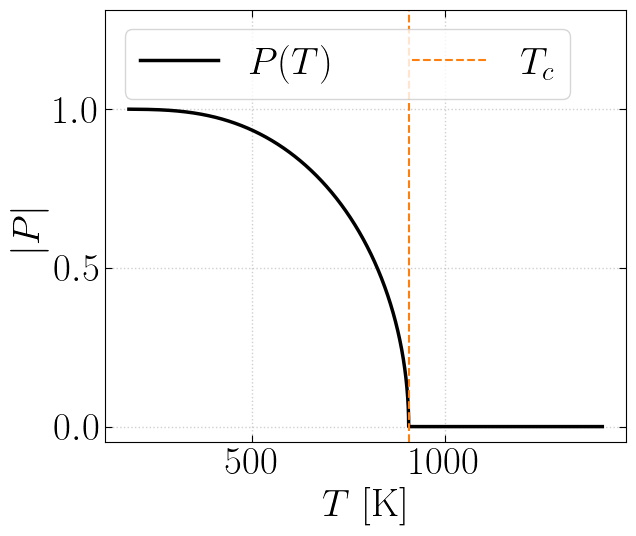

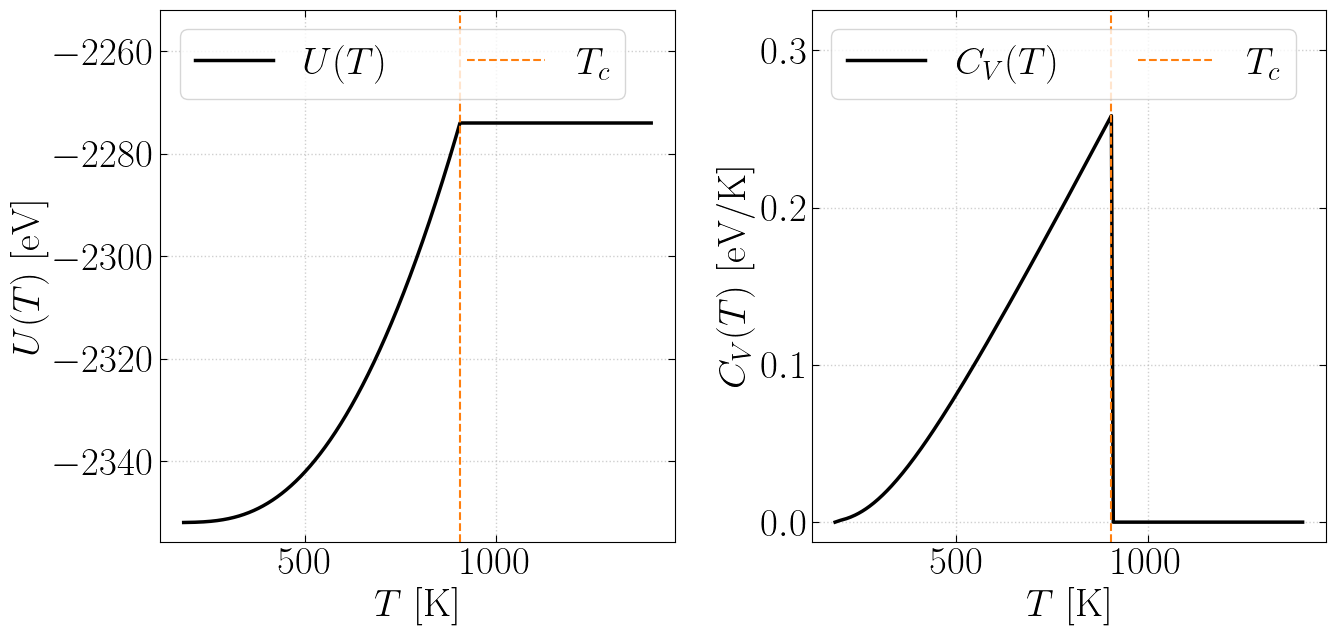

In [ ]:

# Constants
E_cucu = -0.436 # Bond energy for Cu-Cu [eV]
E_znzn = -0.113 # Bond energy for Zn-Zn [eV]
E_cuzn = -0.294 # Bond energy for Cu-Zn [eV]
delta_E = E_cucu + E_znzn - 2*E_cuzn
T_c = 2*delta_E/k_B # Critical temperature [K]
print(f'T_c = {T_c}')

# Read data
data = np.loadtxt('data/task_1/data.csv', delimiter=',')

# Plot data
plot_task_1('P', T_c, save=False)
plot_task_1('UC', T_c, save=False)


### Task 2 - Calculating $U$ using the Metropolis Algorithm 

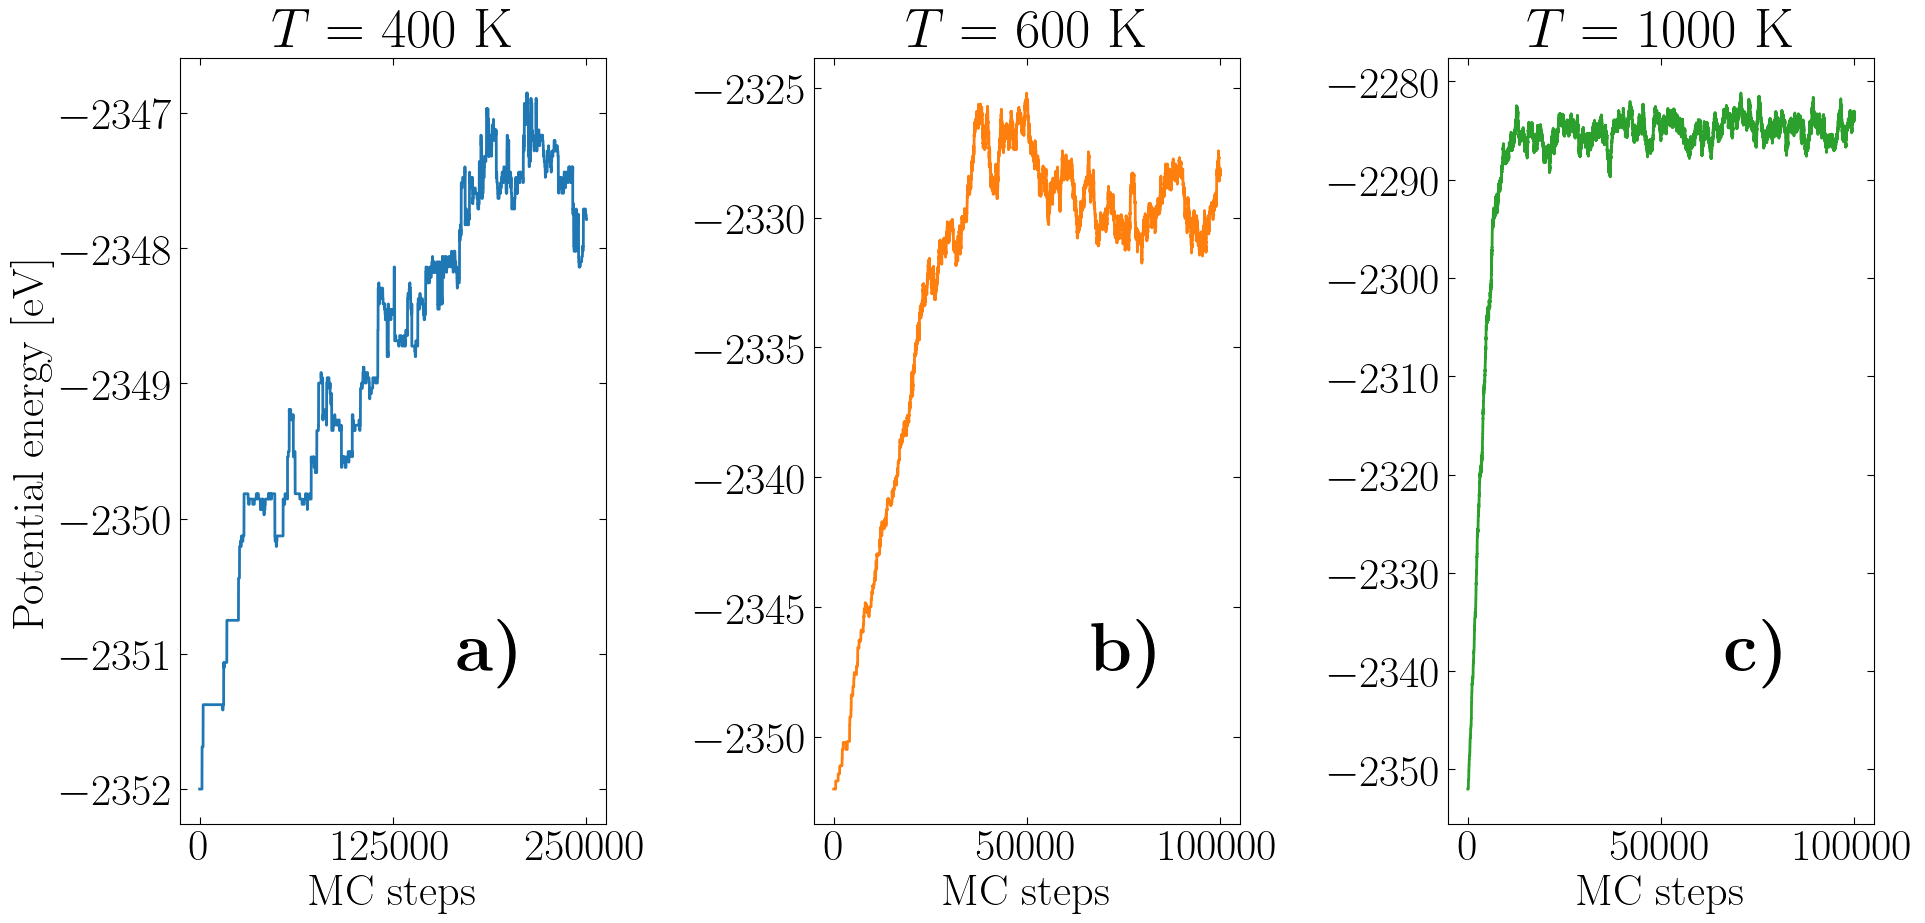

|   $T$ |   $E_{pot}$ |   $N_{eq}$ |   $\text{Acceptance}_{eq}$ |   $\text{Acceptance}$ |
|------:|------------:|-----------:|---------------------------:|----------------------:|
|   400 |    -2348.26 |     250000 |                    0.01772 |              0.02027  |
|   600 |    -2326.52 |     100000 |                    0.10299 |              0.129767 |
|  1000 |    -2284.61 |     100000 |                    0.58997 |              0.622663 |

In [14]:

# Constants
its_eq_400 = 250000
its_eq = 100000
its = 1000000

# Plot equilibrium data
# task_2_analyzer(400, its_eq_400, its, changed=True, plot=True, save=False)
analyzer_task_2([400, 600, 1000], [its_eq_400, its_eq, its_eq], its=None, changed=False, plot=True, save=True)

# Display MC data
U_400, accept_400_eq, accept_400 = analyzer_task_2(400, its_eq_400, its, changed=False, plot=False, save=False)
U_600, accept_600_eq, accept_600 = analyzer_task_2(600, its_eq, its, changed=False, plot=False, save=False)
U_1000, accept_1000_eq, accept_1000 = analyzer_task_2(1000, its_eq, its, changed=False, plot=False, save=False)

df = pd.DataFrame({'$T$': [400, 600, 1000], '$E_{pot}$': [np.mean(U_400), np.mean(U_600), np.mean(U_1000)], 
                   '$N_{eq}$': [its_eq_400, its_eq, its_eq], '$\\text{Acceptance}_{eq}$': [accept_400_eq, accept_600_eq, accept_1000_eq], 
                   '$\\text{Acceptance}$': [accept_400, accept_600, accept_1000]})
markdown = df.to_markdown(index=False)
display(Markdown(markdown))


### Task 3

#### a) Temperature dependence of $U$, $C_V$, $P$ and $r$ using MFT

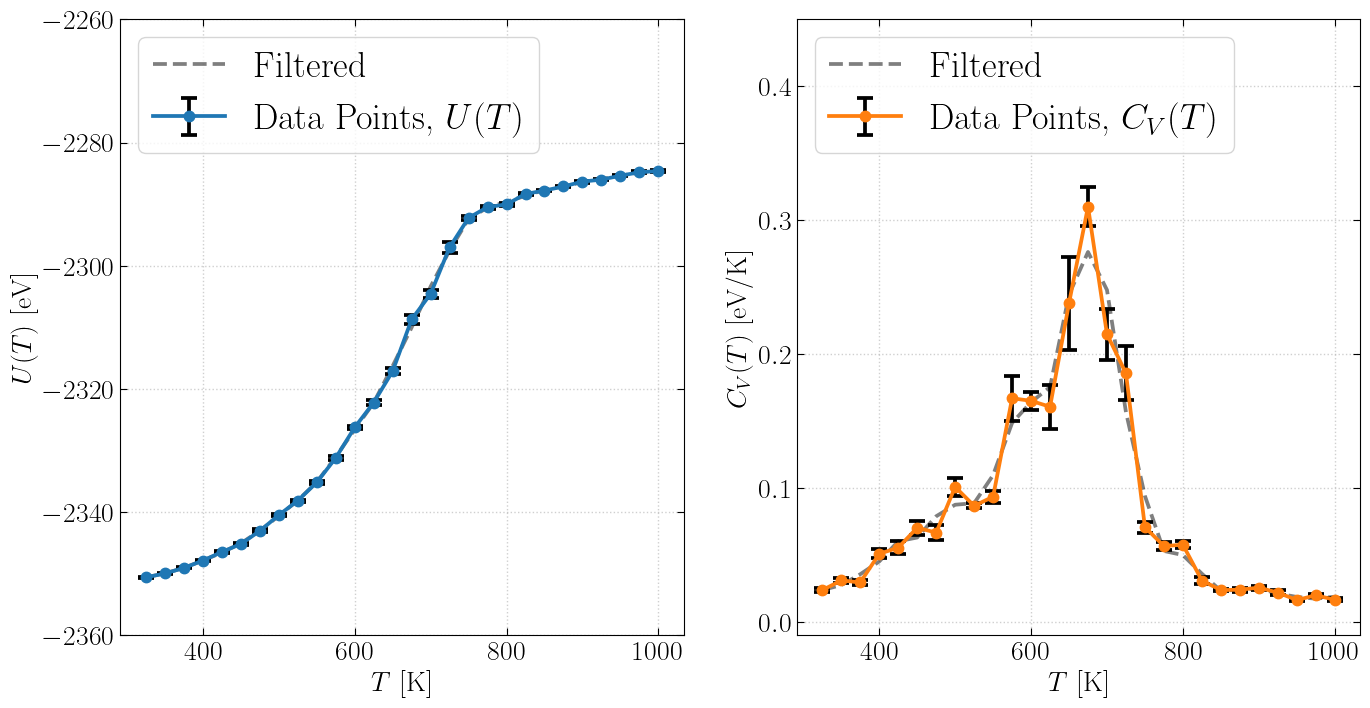

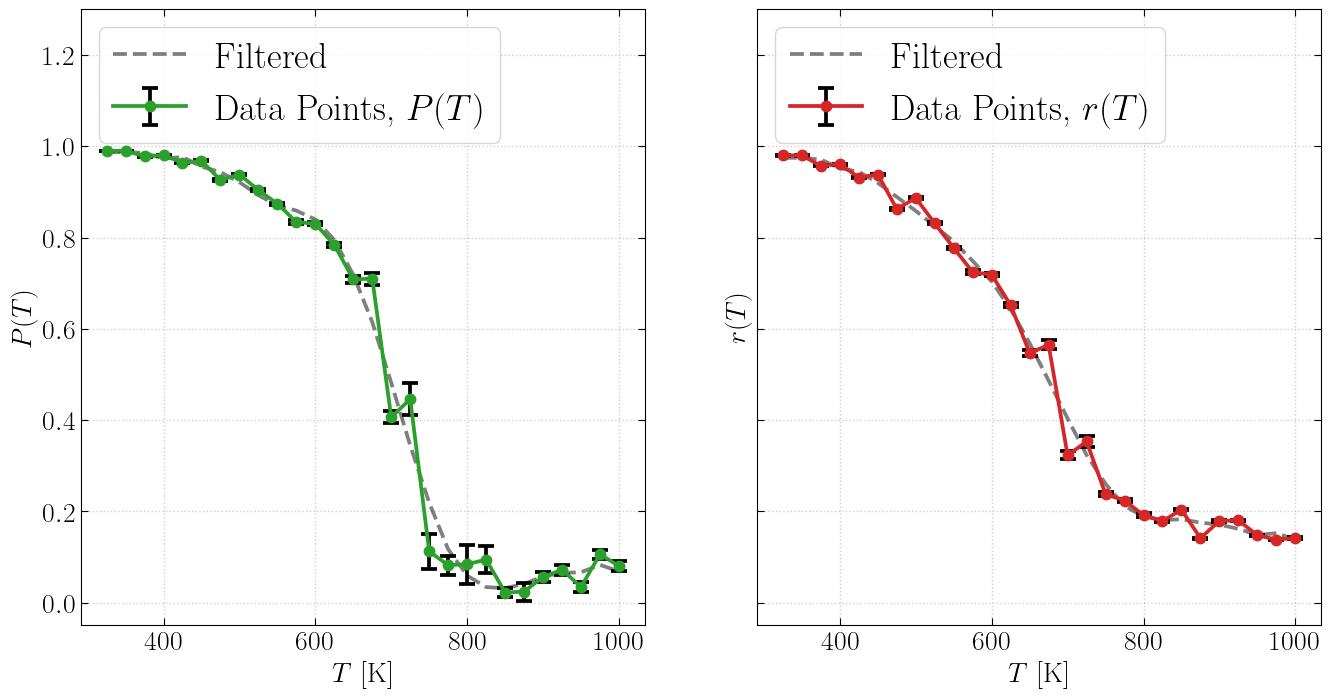

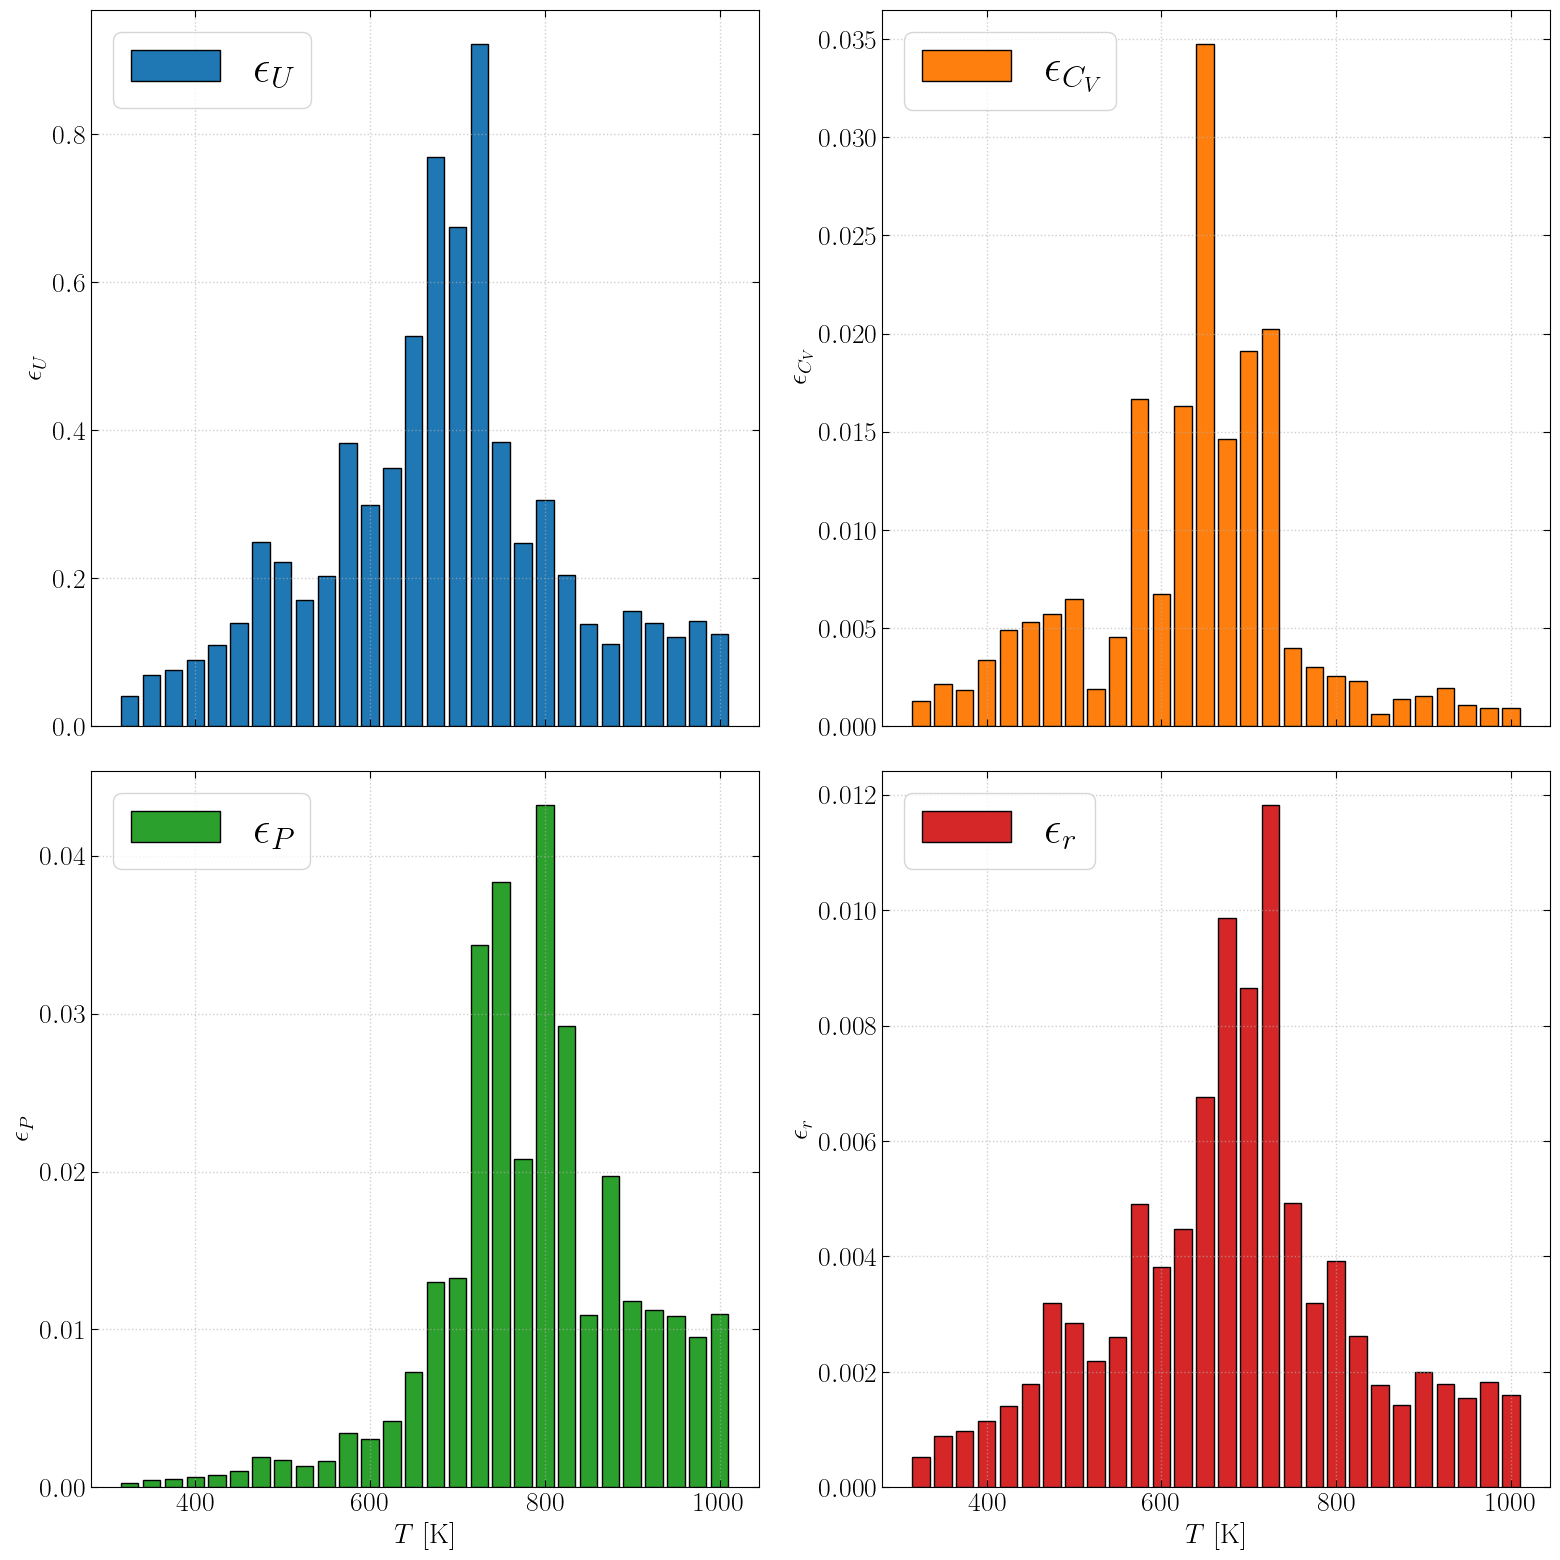

In [159]:

save = False

# Plot the data for task 3
plot_task_3('UC', save=save)
plot_task_3('Pr', save=save, error_plot=True, save_error_plot=False)
# plot_task_3('C_V', save=save)
# plot_task_3('P', save=save)
# plot_task_3('r', save=save)

#### b) Error estimation using block average and autocorrelation

In [ ]:

# Constants
Ts = [300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 
      700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000] # Temperatures
eqs = [250000] * 12 + [100000] * 17 # Equilibrium iterations
errors_corr, errors_block, facts = get_errors(Ts) # Get the errors
# Ts.append('$\\textbf{Mean}$')

# Display the number of samples, iterations and acceptance ratio for each temperature
df = pd.DataFrame({'$T$': Ts, '$N_{\\text{samples}}$': facts['samples'], '$N$': facts['its'], '$N_{\\text{eq}}$': eqs, '$\\text{Acceptance}\\hspace{0.2cm}N_{\\text{samples}} / N$': facts['acceptance']})
md_table = df.to_markdown(index=False)
display(Markdown('### Errors \n' + md_table))

# errors_corr['U'].append(f'$\\textbf{{{np.mean(np.array(errors_corr["U"], dtype=np.float64)):.2e}}}$')
# errors_corr['C_V'].append(f'$\\textbf{{{np.mean(np.array(errors_corr["C_V"], dtype=np.float64)):.2e}}}$')
# errors_corr['P'].append(f'$\\textbf{{{np.mean(np.array(errors_corr["P"], dtype=np.float64)):.2e}}}$')
# errors_corr['r'].append(f'$\\textbf{{{np.mean(np.array(errors_corr["r"], dtype=np.float64)):.2e}}}$')
# facts['samples'].append(f'$\\textbf{{{np.mean(np.array(facts["samples"], dtype=np.float64)):.2e}}}$')
# facts['its'].append(f'$\\textbf{{{np.mean(np.array(facts["its"], dtype=np.float64)):.2e}}}$')
# facts['acceptance'].append(f'$\\textbf{{{100 * np.mean(np.array(facts["acceptance"], dtype=np.float64)):.2f}}}$ %')
# df_corr = pd.DataFrame({'$T$': Ts, '$\\epsilon\\hspace{0.1cm}(U)$': errors_corr['U'], '$\\epsilon\\hspace{0.1cm}(C_V)$': errors_corr['C_V'], '$\\epsilon\\hspace{0.1cm}(P)$': errors_corr['P'], '$\\epsilon\\hspace{0.1cm}(r)$': errors_corr['r'], '$N$': facts['samples'], '$N_{\\text{its}}$': facts['its'], '$\\text{Acceptance}$': facts['acceptance']})
# df_corr['$N_{\\text{its}}$'][:-1] = df_corr['$N_{\\text{its}}$'][:-1].apply(lambda x: f'{x:.0f}')
# df_corr['$\\text{Acceptance}$'][:-1] = df_corr['$\\text{Acceptance}$'][:-1].apply(lambda x: f'{100*x:.2f} %')
# md_table_corr = df_corr.to_markdown(index=False)
# display(Markdown('### Autocorrelation Errors \n' + md_table_corr))

# errors_block['U'].append(f'$\\textbf{{{np.mean(np.array(errors_block["U"], dtype=np.float64)):.2e}}}$')
# errors_block['C_V'].append(f'$\\textbf{{{np.mean(np.array(errors_block["C_V"], dtype=np.float64)):.2e}}}$')
# errors_block['P'].append(f'$\\textbf{{{np.mean(np.array(errors_block["P"], dtype=np.float64)):.2e}}}$')
# errors_block['r'].append(f'$\\textbf{{{np.mean(np.array(errors_block["r"], dtype=np.float64)):.2e}}}$')
# df_block = pd.DataFrame({'$T$': Ts, '$\\epsilon\\hspace{0.1cm}(U)$': errors_block['U'], '$\\epsilon\\hspace{0.1cm}(C_V)$': errors_block['C_V'], '$\\epsilon\\hspace{0.1cm}(P)$': errors_block['P'], '$\\epsilon\\hspace{0.1cm}(r)$': errors_block['r'], '$N$': facts['samples'], '$N_{\\text{its}}$': facts['its'], '$\\text{Acceptance}$': facts['acceptance']})
# df_block['$N_{\\text{its}}$'][:-1] = df_block['$N_{\\text{its}}$'][:-1].apply(lambda x: f'{x:.0f}')
# df_block['$\\text{Acceptance}$'][:-1] = df_block['$\\text{Acceptance}$'][:-1].apply(lambda x: f'{100*x:.2f} %')
# md_table_block = df_block.to_markdown(index=False)
# display(Markdown('### Blocking Errors \n' + md_table_block))


### Errors 
|   $T$ |   $N_{\text{samples}}$ |              $N$ |   $N_{\text{eq}}$ |   $\text{Acceptance}\hspace{0.2cm}N_{\text{samples}} / N$ |
|------:|-----------------------:|-----------------:|------------------:|----------------------------------------------------------:|
|   300 |                 100000 |      2.34094e+07 |            250000 |                                                0.00427179 |
|   325 |                 100000 |      1.35083e+07 |            250000 |                                                0.00740287 |
|   350 |                 100000 |      9.14267e+06 |            250000 |                                                0.0109377  |
|   375 |                 100000 |      6.23558e+06 |            250000 |                                                0.016037   |
|   400 |                 100000 |      4.57791e+06 |            250000 |                                                0.021844   |
|   425 |                 100000 |      3.4423e+06  |            250000 |                                                0.0290504  |
|   450 |                 100000 |      2.84536e+06 |            250000 |                                                0.0351449  |
|   475 |                 100000 |      2.18461e+06 |            250000 |                                                0.0457747  |
|   500 |                 100000 |      1.73153e+06 |            250000 |                                                0.0577523  |
|   525 |                 100000 |      1.43724e+06 |            250000 |                                                0.0695778  |
|   550 |                 100000 |      1.18042e+06 |            250000 |                                                0.0847153  |
|   575 |                 100000 | 956838           |            250000 |                                                0.104511   |
|   600 |                 100000 | 761226           |            100000 |                                                0.131367   |
|   625 |                 100000 | 639335           |            100000 |                                                0.156413   |
|   650 |                 100000 | 525613           |            100000 |                                                0.190254   |
|   675 |                 100000 | 396587           |            100000 |                                                0.252151   |
|   700 |                 100000 | 338243           |            100000 |                                                0.295645   |
|   725 |                 100000 | 263062           |            100000 |                                                0.380139   |
|   750 |                 100000 | 222414           |            100000 |                                                0.449612   |
|   775 |                 100000 | 207469           |            100000 |                                                0.482      |
|   800 |                 100000 | 201814           |            100000 |                                                0.495506   |
|   825 |                 100000 | 190183           |            100000 |                                                0.525809   |
|   850 |                 100000 | 184851           |            100000 |                                                0.540976   |
|   875 |                 100000 | 180285           |            100000 |                                                0.554677   |
|   900 |                 100000 | 174321           |            100000 |                                                0.573654   |
|   925 |                 100000 | 170807           |            100000 |                                                0.585456   |
|   950 |                 100000 | 166573           |            100000 |                                                0.600337   |
|   975 |                 100000 | 162960           |            100000 |                                                0.613648   |
|  1000 |                 100000 | 160843           |            100000 |                                                0.621724   |

100000.0


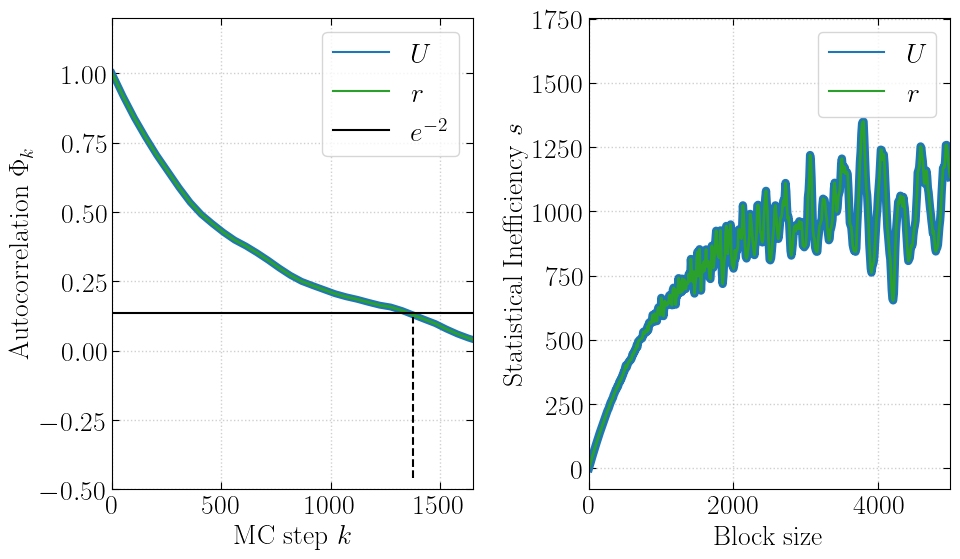

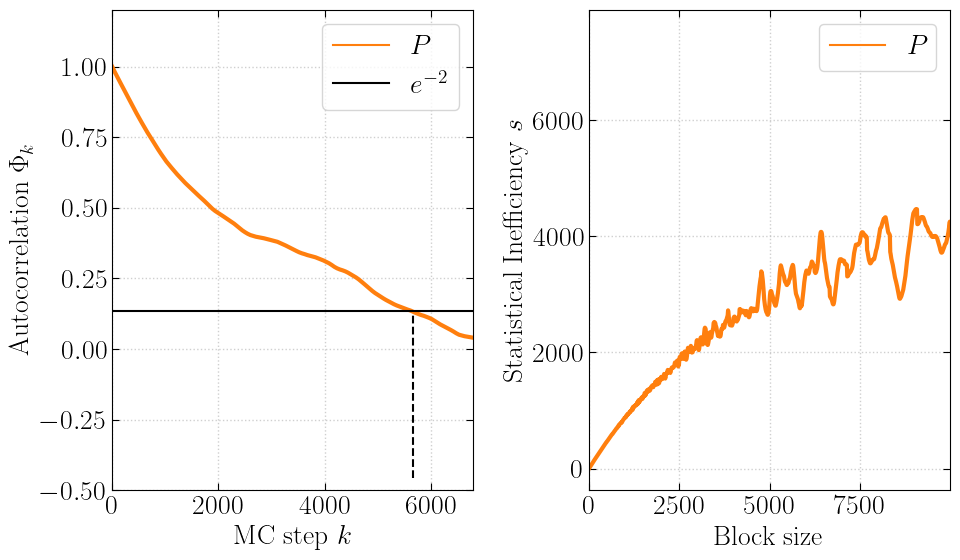

In [158]:

# Constants
T = 1000
save = True

# Read data
N, autocorr, block, error_dict_corr, error_dict_block, var_dict = read_data(3, T)
print(N)
s_corr_U, s_corr_CV = error_dict_corr['U'], error_dict_corr['C_V']
s_corr_P, s_corr_r = error_dict_corr['P'], error_dict_corr['r']

# Plot the error data
plot_task_3_error(T, autocorr, block, s_corr_U, s_corr_P, s_corr_CV, save=save, xlim_factor=0.25, xlim_factor_CVP=0.5, P_sep=True)
